<a href="https://colab.research.google.com/github/jryuuu22/heart-disease-project/blob/main/eclipse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
pip install optuna

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
import os
import re
import optuna
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, average_precision_score, brier_score_loss, confusion_matrix, ConfusionMatrixDisplay

In [3]:
basketball = kagglehub.dataset_download("wyattowalsh/basketball")

Using Colab cache for faster access to the 'basketball' dataset.


In [4]:
os.listdir(basketball)

['nba.sqlite', 'csv']

In [5]:
csv_path = f"{basketball}/csv"

In [6]:
print(os.listdir(csv_path))

['other_stats.csv', 'draft_history.csv', 'team_details.csv', 'player.csv', 'draft_combine_stats.csv', 'team_info_common.csv', 'common_player_info.csv', 'team_history.csv', 'game.csv', 'game_summary.csv', 'officials.csv', 'game_info.csv', 'line_score.csv', 'play_by_play.csv', 'team.csv', 'inactive_players.csv']


In [7]:
#load dataframe from play_by_play csv
df = pd.read_csv(
    f"{csv_path}/play_by_play.csv", nrows=100000
)

In [8]:
#filter event by free throw
keyword = "Free Throw"
filtered_df = df[
    df[["homedescription", "visitordescription"]]
    .apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False))
    .any(axis=1)
]

In [9]:
filtered_df.head()

,game_id,eventnum,eventmsgtype,eventmsgactiontype,period,wctimestring,pctimestring,homedescription,neutraldescription,visitordescription,...,player2_team_nickname,player2_team_abbreviation,person3type,player3_id,player3_name,player3_team_id,player3_team_city,player3_team_nickname,player3_team_abbreviation,video_available_flag
22,29600012,24,3,11,1,14:54 PM,9:24,NaN,NaN,Cassell Free Throw 1 of 2 (1 PTS),...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
24,29600012,26,3,12,1,14:54 PM,9:24,NaN,NaN,Cassell Free Throw 2 of 2 (2 PTS),...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
30,29600012,32,3,11,1,14:56 PM,8:37,Campbell Free Throw 1 of 2 (1 PTS),NaN,NaN,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
31,29600012,33,3,12,1,14:56 PM,8:37,MISS Campbell Free Throw 2 of 2,NaN,NaN,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
44,29600012,46,3,11,1,14:58 PM,7:23,NaN,NaN,Person Free Throw 1 of 2 (3 PTS),...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0


In [10]:
#Clean dataframe
filtered_df = filtered_df.drop(columns=[
    'neutraldescription', 'video_available_flag',
    'person1type','player1_team_nickname', 'player1_team_abbreviation', 'player1_id', 'player1_name', 'player1_team_city', 'player1_team_id',
    'person2type','player2_team_nickname', 'player2_team_abbreviation', 'player2_id', 'player2_name', 'player2_team_city', 'player2_team_id',
    'person3type','player3_team_nickname', 'player3_team_abbreviation', 'player3_id', 'player3_name', 'player3_team_city', 'player3_team_id'])

In [11]:
filtered_df[['score','scoremargin']].isna().sum()

,0
score,3077
scoremargin,3077


In [12]:
#Create a new column in dataframe where if the description contains word 'miss' than it assigns the value to 0 and if else it assigns the value to 1
keyword = 'MISS'

miss_mask = filtered_df[['homedescription', 'visitordescription']].apply(
    lambda row: row.astype(str).str.contains(keyword, case=False, na=False).any(),
    axis=1
)

filtered_df.loc[:, 'FT_made'] = (~miss_mask).astype(int)

In [13]:
filtered_df['scoremargin'] = filtered_df['scoremargin'].fillna('0')

In [14]:
filtered_df['scoremargin'].isna().sum()

np.int64(0)

In [15]:
filtered_df['FT_made'].value_counts()

,count
FT_made,
1,8301
0,3077


In [16]:
def extract_player_name(description):
    """Extract player name from free throw description"""
    if pd.isna(description):
        return None
    # Pattern: "PlayerName Free Throw..." or "MISS PlayerName Free Throw..."
    match = re.search(r'^(?:MISS\s+)?([A-Za-z\.\s]+?)\s+Free Throw', str(description))
    return match.group(1).strip() if match else None

filtered_df['player_name'] = filtered_df.apply(
    lambda row: extract_player_name(row['homedescription']) or extract_player_name(row['visitordescription']),
    axis=1
)
# Convert pctimestring to seconds remaining
def time_to_seconds(time_str):
    """Convert MM:SS to total seconds"""
    if pd.isna(time_str):
        return None
    try:
        parts = str(time_str).split(':')
        return int(parts[0]) * 60 + int(parts[1])
    except:
        return None

filtered_df['seconds_remaining'] = filtered_df['pctimestring'].apply(time_to_seconds)

# Define clutch situations (last 5 minutes of 4th quarter/OT)
filtered_df['is_clutch'] = (
    (filtered_df['period'] >= 4) &
    (filtered_df['seconds_remaining'] <= 300)
).astype(int)

# Parse score margin (convert "71 - 85" to numeric difference)
def parse_score_margin(score_str):
    """Extract point differential from score string"""
    if pd.isna(score_str):
        return None
    try:
        home, away = score_str.split(' - ')
        return abs(int(home) - int(away))
    except:
        return None

filtered_df['point_differential'] = filtered_df['score'].apply(parse_score_margin)

# High pressure = clutch time AND close game (within 5 points)
filtered_df['high_pressure'] = (
    (filtered_df['is_clutch'] == 1) &
    (filtered_df['point_differential'] <= 5)
).astype(int)

In [17]:
# Group by player to calculate baseline statistics
player_stats = filtered_df.groupby('player_name').agg({
    'FT_made': ['sum', 'count', 'mean'],
    'is_clutch': 'sum',
    'high_pressure': 'sum'
}).reset_index()

player_stats.columns = ['player_name', 'ft_made_total', 'ft_attempts', 'overall_ft_pct',
                        'clutch_attempts', 'high_pressure_attempts']

# Calculate clutch-specific performance
clutch_stats = filtered_df[filtered_df['is_clutch'] == 1].groupby('player_name').agg({
    'FT_made': 'mean'
}).reset_index()
clutch_stats.columns = ['player_name', 'clutch_ft_pct']

high_pressure_stats = filtered_df[filtered_df['high_pressure'] == 1].groupby('player_name').agg({
    'FT_made': 'mean'
}).reset_index()
high_pressure_stats.columns = ['player_name', 'high_pressure_ft_pct']

# Merge all player statistics
player_stats = player_stats.merge(clutch_stats, on='player_name', how='left')
player_stats = player_stats.merge(high_pressure_stats, on='player_name', how='left')

# Calculate "clutch factor" = clutch FT% - overall FT%
player_stats['clutch_factor'] = player_stats['clutch_ft_pct'] - player_stats['overall_ft_pct']

# Filter for players with meaningful sample size (e.g., at least 20 FT attempts)
player_stats_filtered = player_stats[player_stats['ft_attempts'] >= 20]

print(f"Players with 20+ FT attempts: {len(player_stats_filtered)}")
player_stats_filtered.sort_values('clutch_factor', ascending=False).head(10)

Players with 20+ FT attempts: 173


,player_name,ft_made_total,ft_attempts,overall_ft_pct,clutch_attempts,high_pressure_attempts,clutch_ft_pct,high_pressure_ft_pct,clutch_factor
156,Mashburn,13,22,0.590909,4,4,1.000000,1.0,0.409091
66,Divac,24,38,0.631579,3,0,1.000000,NaN,0.368421
100,Green,25,38,0.657895,2,0,1.000000,NaN,0.342105
266,Vaughn,16,24,0.666667,2,0,1.000000,NaN,0.333333
267,Vaught,22,33,0.666667,2,0,1.000000,NaN,0.333333
98,Goldwire,19,26,0.730769,7,4,1.000000,1.0,0.269231
204,Perkins,37,50,0.740000,2,2,1.000000,1.0,0.260000
60,Davis,49,81,0.604938,22,2,0.863636,1.0,0.258698
38,Campbell,48,63,0.761905,8,4,1.000000,1.0,0.238095
91,Garnett,30,44,0.681818,10,5,0.900000,1.0,0.218182


In [18]:
player_stats_filtered.sort_values('clutch_factor').head()

,player_name,ft_made_total,ft_attempts,overall_ft_pct,clutch_attempts,high_pressure_attempts,clutch_ft_pct,high_pressure_ft_pct,clutch_factor
7,Askew,21,28,0.750000,2,0,0.000000,NaN,-0.750000
276,Wesley,16,24,0.666667,2,0,0.000000,NaN,-0.666667
277,West,22,29,0.758621,3,1,0.333333,1.0,-0.425287
235,Russell,28,41,0.682927,3,0,0.333333,NaN,-0.349593
150,Maloney,20,29,0.689655,10,1,0.400000,1.0,-0.289655


In [19]:
#Compute Season Ft% for each player
season_ft = (
    filtered_df.groupby('player_name')['FT_made']
    .mean()
    .reset_index()
    .rename(columns={'FT_made': 'season_FT_pct'})
)

In [20]:
#merge it back into main DF
filtered_df = filtered_df.merge(season_ft, on='player_name', how='left')

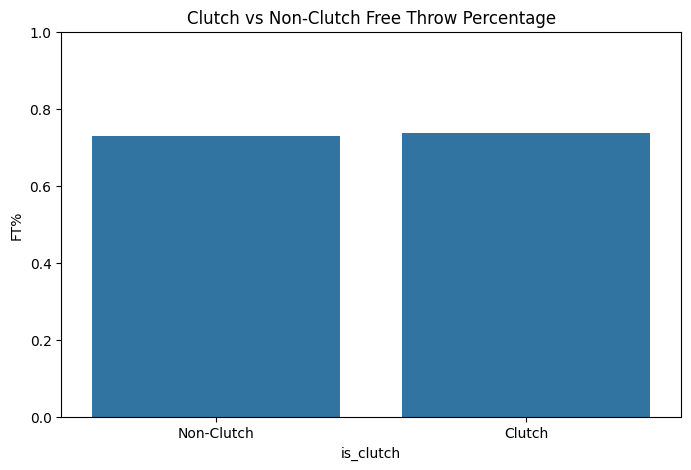

In [21]:
#Cluth vs Non-Clutch FT%
clutch_ft = filtered_df.groupby('is_clutch')['FT_made'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=clutch_ft, x='is_clutch', y='FT_made')
plt.title("Clutch vs Non-Clutch Free Throw Percentage")
plt.xticks([0,1], ['Non-Clutch', 'Clutch'])
plt.ylabel("FT%")
plt.ylim(0, 1)
plt.show()

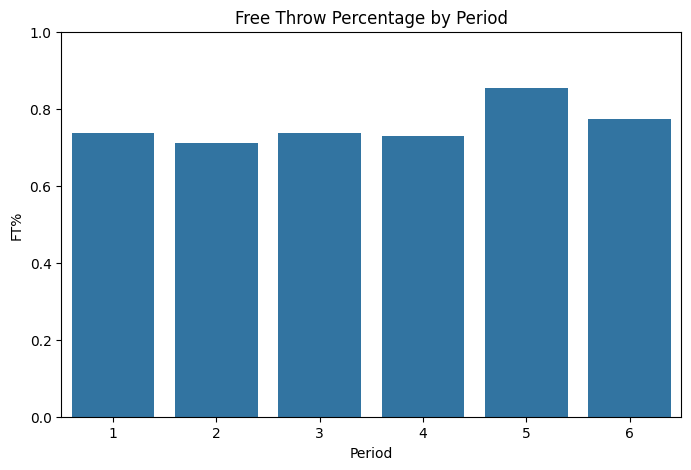

In [22]:
period_ft = filtered_df.groupby('period')['FT_made'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=period_ft, x='period', y='FT_made')
plt.title("Free Throw Percentage by Period")
plt.ylabel("FT%")
plt.xlabel("Period")
plt.ylim(0, 1)
plt.show()

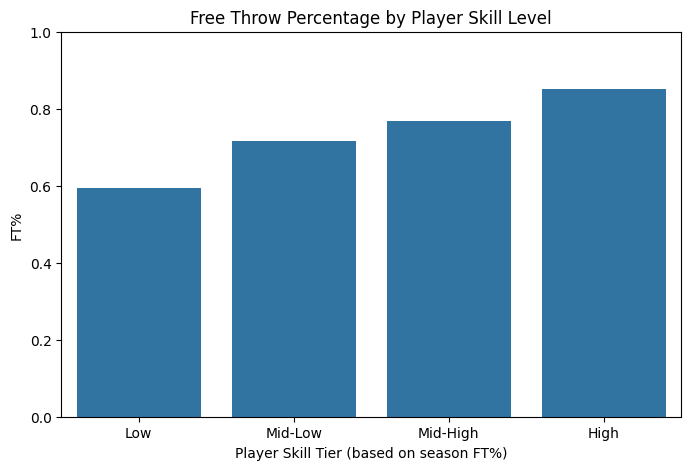

In [23]:
df_skill = filtered_df.dropna(subset=['season_FT_pct']).copy()

# Create skill tier buckets using quartiles
df_skill['skill_bucket'] = pd.qcut(
    df_skill['season_FT_pct'],
    q=4,
    labels=['Low', 'Mid-Low', 'Mid-High', 'High']
)

# Compute FT% within each bucket
skill_ft = (
    df_skill.groupby('skill_bucket',observed=True)['FT_made']
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=skill_ft, x='skill_bucket', y='FT_made')

plt.title("Free Throw Percentage by Player Skill Level")
plt.xlabel("Player Skill Tier (based on season FT%)")
plt.ylabel("FT%")
plt.ylim(0, 1)

plt.show()

In [24]:
filtered_df = filtered_df.merge(
    player_stats[['player_name', 'overall_ft_pct', 'clutch_ft_pct', 'clutch_factor']],
    on='player_name',
    how='left'
)

print("Added player stats to main dataframe")
print(f"Shape: {filtered_df.shape}")
filtered_df[['player_name', 'overall_ft_pct', 'clutch_ft_pct', 'FT_made']].head()

Added player stats to main dataframe
Shape: (11378, 21)


,player_name,overall_ft_pct,clutch_ft_pct,FT_made
0,Cassell,0.883333,0.888889,1
1,Cassell,0.883333,0.888889,1
2,Campbell,0.761905,1.000000,1
3,Campbell,0.761905,1.000000,0
4,Person,0.850000,1.000000,1


In [25]:
filtered_df['close_game'] = (filtered_df['point_differential'] <= 3).astype(int)

print("Close game distribution:")
print(filtered_df['close_game'].value_counts())

Close game distribution:
close_game
0    8951
1    2427
Name: count, dtype: int64


In [26]:
filtered_df['late_game'] = (filtered_df['period'] >= 4).astype(int)

print("Late game distribution:")
print(filtered_df['late_game'].value_counts())

Late game distribution:
late_game
0    7661
1    3717
Name: count, dtype: int64


Pressure score distribution:
pressure_score
0    5564
1    3841
2    1747
3     226
Name: count, dtype: int64


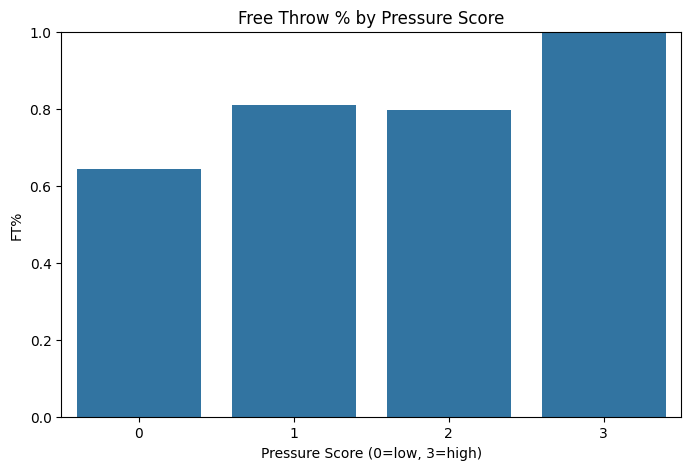

In [27]:
filtered_df['pressure_score'] = (
    filtered_df['is_clutch'].astype(int) +
    filtered_df['close_game'].astype(int) +
    (filtered_df['seconds_remaining'] <= 120).astype(int)
)
# Score of 3 = clutch time + close game + under 2 minutes (maximum pressure)
# Score of 0 = none of these factors (low pressure)
print("Pressure score distribution:")
print(filtered_df['pressure_score'].value_counts().sort_index())
pressure_performance = filtered_df.groupby('pressure_score')['FT_made'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=pressure_performance, x='pressure_score', y='FT_made')
plt.title("Free Throw % by Pressure Score")
plt.xlabel("Pressure Score (0=low, 3=high)")
plt.ylabel("FT%")
plt.ylim(0, 1)
plt.show()


In [28]:
career_attempts = filtered_df.groupby('player_name').size().to_dict()
filtered_df['career_attempts_so_far'] = filtered_df['player_name'].map(career_attempts)

print(f"Career attempts range: {filtered_df['career_attempts_so_far'].min()} to {filtered_df['career_attempts_so_far'].max()}")


Career attempts range: 1.0 to 194.0


In [29]:
player_stats.head()

,player_name,ft_made_total,ft_attempts,overall_ft_pct,clutch_attempts,high_pressure_attempts,clutch_ft_pct,high_pressure_ft_pct,clutch_factor
0,A. Davis,31,51,0.607843,5,1,0.400000,1.0,-0.207843
1,Alexander,7,12,0.583333,6,0,0.833333,NaN,0.250000
2,Allen,35,48,0.729167,13,5,0.692308,1.0,-0.036859
3,Alston,0,2,0.000000,2,0,0.000000,NaN,0.000000
4,Anderson,106,149,0.711409,40,11,0.600000,1.0,-0.111409


In [47]:

# Create a feature column
feature_cols = [
    # player features
    'season_FT_pct',
    'overall_ft_pct',
    'clutch_ft_pct',
    'clutch_factor',
    'career_attempts_so_far',
    #pressure/context
    'period',
    'seconds_remaining',
    'is_clutch',
    'close_game',
    'late_game',
    'pressure_score',
    'point_differential'
]


# create df where we have all needed values
model_df = filtered_df[feature_cols+['FT_made', 'game_id']].copy()
model_df = model_df.dropna(subset=['FT_made', 'game_id'])

# Ensure scoremargin is numeric
#model_df["scoremargin"] = pd.to_numeric(model_df["scoremargin"], errors="coerce")

X = model_df[feature_cols].copy()
y = model_df['FT_made'].copy()

# Get the unique game IDS
game_ids = model_df['game_id'].unique()

# Split game_ids into train and test
train_games, test_games = train_test_split(game_ids, test_size=0.2, shuffle=False)

train_mask = model_df['game_id'].isin(train_games)
test_mask = model_df['game_id'].isin(test_games)

X_train = X[train_mask].copy()
X_test  = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test  = y[test_mask].copy()

# Impute missing values
imputer = SimpleImputer(strategy='median')

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.fit_transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Scale with StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# Save CSVs
X_train_scaled.to_csv("X_train.csv", index=False)
X_test_scaled.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [51]:
# Split training/validation data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state = 42
)

# Logistic Regression
def logreg(trial):
  params = {
      "C": trial.suggest_float("C", 1e-3, 100.0, log=True),
      "penalty": "l2",
      "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
      "max_iter": trial.suggest_int("max_iter", 200, 1000),
      'random_state': 42
  }

  model=LogisticRegression(**params)
  model.fit(X_tr, y_tr)
  y_proba = model.predict_proba(X_val)[:,1]

  pr_auc = average_precision_score(y_val, y_proba)
  return pr_auc

#Random Forest Object
def rf(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 600),
      'max_depth': trial.suggest_int('max_depth', 2, 20),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
      'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
      'random_state': 42
      }

  model = RandomForestClassifier(**params)
  model.fit(X_tr, y_tr)
  y_proba = model.predict_proba(X_val)[:,1]

  pr_auc = average_precision_score(y_val, y_proba)
  return pr_auc

#XG Boost Objective
def xgb(trial):
  params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 600),
      'max_depth': trial.suggest_int('max_depth', 2, 20),
      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
      'objective': 'binary:logistic',
      'eval_metric': 'logloss',
      'random_state': 42
      }
  model = XGBClassifier(**params)
  model.fit(X_tr, y_tr)
  y_proba = model.predict_proba(X_val)[:,1]

  pr_auc = average_precision_score(y_val, y_proba)
  return pr_auc

In [53]:
#Logistic Regressing tuning
study_logreg = optuna.create_study(direction='maximize', study_name='logreg_pr_auc')
study_logreg.optimize(logreg, n_trials=30)

#Random Forest tuning
study_rf = optuna.create_study(direction='maximize', study_name='rf_pr_auc')
study_rf.optimize(rf, n_trials=30)

#XBG Tuning
study_xgb = optuna.create_study(direction='maximize', study_name='xgb_pr_auc')
study_xgb.optimize(xgb, n_trials=30)

[I 2025-11-20 04:00:42,729] A new study created in memory with name: logreg_pr_auc
[I 2025-11-20 04:00:42,762] Trial 0 finished with value: 0.9388550767470424 and parameters: {'C': 4.355585926278633, 'solver': 'lbfgs', 'max_iter': 300}. Best is trial 0 with value: 0.9388550767470424.
[I 2025-11-20 04:00:42,812] Trial 1 finished with value: 0.9388525710918172 and parameters: {'C': 9.534359756343228, 'solver': 'liblinear', 'max_iter': 495}. Best is trial 0 with value: 0.9388550767470424.
[I 2025-11-20 04:00:42,856] Trial 2 finished with value: 0.9389125098665733 and parameters: {'C': 0.5807007681911649, 'solver': 'liblinear', 'max_iter': 630}. Best is trial 2 with value: 0.9389125098665733.
[I 2025-11-20 04:00:42,882] Trial 3 finished with value: 0.939022069746615 and parameters: {'C': 0.1540678772425075, 'solver': 'lbfgs', 'max_iter': 213}. Best is trial 3 with value: 0.939022069746615.
[I 2025-11-20 04:00:42,916] Trial 4 finished with value: 0.9391060310183719 and parameters: {'C': 0.0

In [55]:
#Display best score and params
print("Best LogReg Score", study_logreg.best_value)
print("Best LogReg params:", study_logreg.best_params)

print("Best RandomForest Score:", study_rf.best_value)
print("Best RandomForest params:", study_rf.best_params)

print("Best XGB Score", study_xgb.best_value)
print("Best XGB params:", study_xgb.best_params)

Best LogReg Score 0.9391112198856567
Best LogReg params: {'C': 0.06096571903095443, 'solver': 'liblinear', 'max_iter': 537}
Best RandomForest Score: 0.9940602148018943
Best RandomForest params: {'n_estimators': 311, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'log2'}
Best XGB Score 0.993978895395103
Best XGB params: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.013291303507364651, 'subsample': 0.5286976244488903, 'colsample_bytree': 0.7494767708213381, 'reg_lambda': 0.0011056153327238295}


In [68]:
scores = {
    'Logistic Regression': study_logreg.best_value,
    'Random Forest': study_rf.best_value,
    'XG Boost': study_xgb.best_value
}

for model, score in scores.items():
    print(f"{model} PR-AUC: {score:.4f}")

best_model = max(scores, key=scores.get)
print('Winning model:', best_model)



Logistic Regression PR-AUC: 0.9391
Random Forest PR-AUC: 0.9941
XG Boost PR-AUC: 0.9940
Winning model: Random Forest


In [85]:
# Find best params for winning model
rf_best_params = study_rf.best_params

#train winning model
rf_best_params.update({
    'max_samples': None,
    'n_jobs':-1,
    'random_state':42
})

final_rf = RandomForestClassifier(**rf_best_params)
final_rf.fit(X_train_scaled, y_train)

y_proba_test = final_rf.predict_proba(X_test_scaled)[:,1]
y_pred_test = final_rf.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_proba_test)
test_brier = brier_score_loss(y_test, y_proba_test)

In [89]:
#Display accuracy, average_precision, and brier score
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test PR-AUC: {test_pr_auc:.4f}')
print(f'Brier Score: {test_brier:.4f}')

Test Accuracy: 0.9523
Test PR-AUC: 0.9930
Brier Score: 0.0513


In [103]:
# Generate Feature Importance Ranking
feature_importance = pd.DataFrame({
    'feature':X_train_scaled.columns,
    'importance':final_rf.feature_importances_
    })
feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
0,point_differential,0.772442
1,close_game,0.084668
2,season_FT_pct,0.039151
3,overall_ft_pct,0.035471
4,pressure_score,0.020419
5,clutch_ft_pct,0.011712
6,seconds_remaining,0.011020
7,period,0.008027
8,clutch_factor,0.007288
9,career_attempts_so_far,0.004946


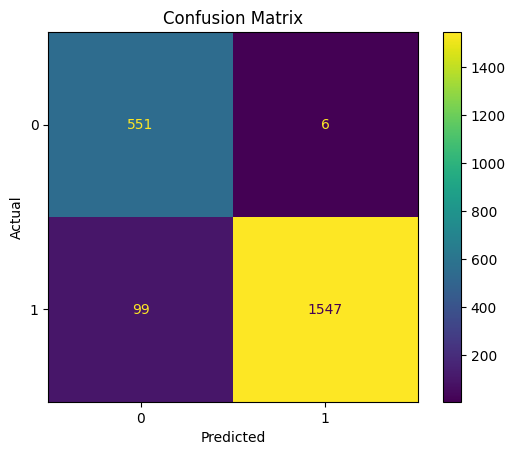

In [113]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix displays the accuracy of our model. With FT_made=0 being a miss and FT_made=1 being a make, our model had a total 2203 samples with 551 being true negatives, 6 being false positives, 99 being false negatives, and 1547 being true positives. The model holds strong predictive capability  and rarely predicted the wrong result. When the model did predict wrong, it tends to underestimate whether the FT made rather than overestimate whether the FT made when the model was wrong. Overall, the confusion matrix displays the reliability of the model, maintaining an extremely low false-positive rate.

In [117]:
# Save model as pickle file
pickle.dump(final_rf, open('final_rf.pkl', 'wb'))

#Load model
loaded_model = pickle.load(open('final_rf.pkl', 'rb'))